In [ ]:
################################################################################
# Remove columns with mean 0 and remove duplicate rows
################################################################################

import numpy as np
import os
import pandas as pd
from tqdm import tqdm

path = os.getcwd() + '/../data/cic-iot/CSV/'
dfs = []
for file_name in tqdm(os.listdir(path), ncols=100, desc='Reading CSVs...'):
    if file_name.endswith('.csv'):
        dfs.append(pd.read_csv(path + file_name).sample(n=10000, random_state=42))
df = pd.concat(dfs, ignore_index=True)

# remove columns if mean is 0
columns_to_drop = []
for c in df.select_dtypes(include=[np.number]).columns:
    if df[c].mean() == 0:
        columns_to_drop.append(c)
print("Columns to drop: ", columns_to_drop)

# get df with removed columns
df_with_dropped_columns = df.drop(columns_to_drop, axis=1)
print("Number of columns before removing columns: ", len(df.columns))
print("Number of columns after removing columns: ", len(df_with_dropped_columns.columns))

# remove duplicate rows
df_no_duplicates = df_with_dropped_columns.drop_duplicates()
print("Length of dataset before removing duplicates: ", len(df_with_dropped_columns))
print("Length of dataset after removing duplicates: ", len(df_no_duplicates))

# save to csv
df_no_duplicates.to_csv(os.getcwd() + '/data/population.csv', index=False)


In [10]:
################################################################################
# Split and save dataset
################################################################################

import os
import pandas as pd

df = pd.read_csv(os.getcwd() + '/data/population.csv', low_memory=False)

sample_size = 100000

# sample_df = pd.concat([
#     df[df['label'] == 'BenignTraffic'].sample(n=sample_size//2, random_state=42),
#     df[df['label'] != 'BenignTraffic'].sample(n=sample_size//2, random_state=42)
#     ])

sample_df = pd.concat([
    df[df['label'] == 'BenignTraffic'].sample(n=10800, random_state=42),
    df[df['label'] != 'BenignTraffic'].sample(n=(sample_size-10800), random_state=42)
    ])

print("Length of dataset: ", len(sample_df))
sample_df.to_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv', index=False)

Length of dataset:  100000


Text(0.5, 1.0, 'Record Count')

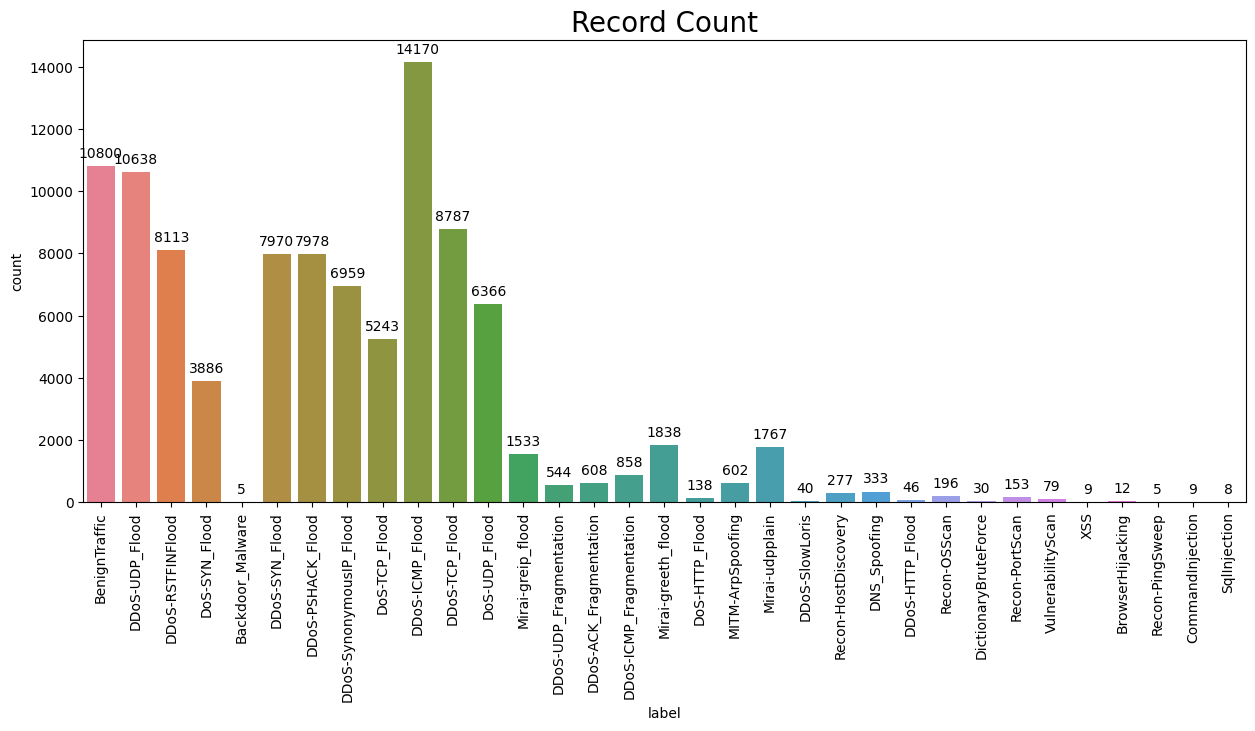

In [11]:
################################################################################
# Class distribution
################################################################################

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

sample_size = 100000

saved_sample_df = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv', low_memory=False)

plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
s = sns.countplot(data=saved_sample_df, x='label', hue='label')
for p in s.patches:
    s.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
plt.title('Record Count', fontsize=20)

In [5]:
################################################################################
# Load dataset and split it into training and test set
################################################################################

import pandas as pd
import os
from tabulate import tabulate

sample_size = 100000

# Load dateset
df = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv')

# Split dataset according to attack type
normal_df = df[df['label'] == 'BenignTraffic']
attack_df = df[df['label'] != 'BenignTraffic']

# Drop columns
normal_df = normal_df.drop(columns=['label'])
attack_df = attack_df.drop(columns=['label'])

# Split dataset into training and test set
normal_df_train = normal_df.sample(frac=0.8, random_state=42)
normal_df_test = normal_df.drop(normal_df_train.index)
attack_df_train = attack_df.sample(frac=0.8, random_state=42)
attack_df_test = attack_df.drop(attack_df_train.index)

# Print dataset sizes in a table
data = [
    ["Normal", normal_df.shape[0], normal_df_train.shape[0], normal_df_test.shape[0]],
    ["Attack", attack_df.shape[0], attack_df_train.shape[0], attack_df_test.shape[0]]
]
print(tabulate(data, headers=["Atack type", "Total", "Train", "Test"], tablefmt="grid"))

+--------------+---------+---------+--------+
| Atack type   |   Total |   Train |   Test |
+==============+=========+=========+========+
| Normal       |   10800 |    8640 |   2160 |
+--------------+---------+---------+--------+
| Attack       |   89200 |   71360 |  17840 |
+--------------+---------+---------+--------+


In [ ]:
################################################################################
# Add documents to vector store
################################################################################

from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from tqdm import tqdm

# Initialize embeddings
embeddings = HuggingFaceEmbeddings()

# Initialize vector store
vector_store = Chroma(
    collection_name="cic-iot",
    embedding_function=embeddings, 
    persist_directory=f"./vector-stores/chroma-db-{sample_size}-2")

# Add batched documents to vector store
batch_size = 16
total_normal_documents = normal_df_train.shape[0]
total_attack_documents = attack_df_train.shape[0]

for i in tqdm(range(0, total_normal_documents, batch_size), ncols=100, desc="Adding normal documents to vector store"):
    documents = [Document(page_content=str(normal_df_train.iloc[i+j].to_list()), metadata={"source": "cic-iot", "label": "normal"}) for j in range(min(batch_size, total_normal_documents-i))]
    vector_store.add_documents(documents)

for i in tqdm(range(0, total_attack_documents, batch_size), ncols=100, desc="Adding attack documents to vector store"):
    documents = [Document(page_content=str(attack_df_train.iloc[i+j].to_list()), metadata={"source": "cic-iot", "label": "attack"}) for j in range(min(batch_size, total_attack_documents-i))]
    vector_store.add_documents(documents)

print(f"Total number of documents added: {total_attack_documents+total_normal_documents}")

c:\Users\S4025371\OneDrive - RMIT University\Repositories\iot-llm\.conda\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\S4025371\OneDrive - RMIT University\Repositories\iot-llm\.conda\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\S4025371\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To suppor

Total number of documents added: 80000


In [6]:
################################################################################
# Add documents to vector store (test set)
################################################################################

from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from tqdm import tqdm

# Initialize embeddings
embeddings = HuggingFaceEmbeddings()

# Initialize vector store
vector_store = Chroma(
    collection_name="cic-iot-test",
    embedding_function=embeddings, 
    persist_directory=f"./vector-stores/chroma-db-{sample_size}-2-test")

# Add batched documents to vector store
batch_size = 16
total_normal_documents = normal_df_test.shape[0]
total_attack_documents = attack_df_test.shape[0]

for i in tqdm(range(0, total_normal_documents, batch_size), ncols=100, desc="Adding normal documents to vector store"):
    documents = [Document(page_content=str(normal_df_test.iloc[i+j].to_list()), metadata={"source": "cic-iot-test", "label": "normal"}) for j in range(min(batch_size, total_normal_documents-i))]
    vector_store.add_documents(documents)

for i in tqdm(range(0, total_attack_documents, batch_size), ncols=100, desc="Adding attack documents to vector store"):
    documents = [Document(page_content=str(attack_df_test.iloc[i+j].to_list()), metadata={"source": "cic-iot-test", "label": "attack"}) for j in range(min(batch_size, total_attack_documents-i))]
    vector_store.add_documents(documents)

print(f"Total number of documents added: {total_attack_documents+total_normal_documents}")

c:\Users\S4025371\OneDrive - RMIT University\Repositories\iot-llm\.conda\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Adding attack documents to vector store: 100%|████████████████| 1115/1115 [2:14:16<00:00,  7.23s/it]

Total number of documents added: 20000
